# Testing data simulation with covariance shrinkage

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import importlib

### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


## Simulate

In [4]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=False, return_R=True)
data_null_gen

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:218: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F = np.array([dist_cdf_selector(X[:, j], means[j], overdisps[j], zinfs[j]) for j in range(p)]).T
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F1 = np.array([dist_cdf_selector(X[:, j] + 1, means[j], overdisps[j], zinfs[j]) for j in range(p)]).T
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eig

R_est is not positive definite! Adjusting eigenvalues...


/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:259: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_gen = np.array([dist_ppf_selector(Z_cdf[:, j], means[j], overdisps[j], zinfs[j]) for j in


AnnData object with n_obs × n_vars = 1544 × 5553

In [5]:
data_null_gen.var_names = data_gene.var_names
print(data_null_gen.X)

[[0. 0. 2. ... 1. 1. 1.]
 [0. 0. 2. ... 3. 6. 0.]
 [1. 0. 0. ... 0. 2. 0.]
 ...
 [1. 1. 2. ... 1. 9. 2.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [6]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [7]:
data_null_gen.var

,var_counts,mean_counts
PAO1_ID,,
PA0001,0.746636,0.659326
PA0002,0.613854,0.488342
PA0003,1.018289,0.898964
PA0004,0.394537,0.363342
PA0005,0.124753,0.123057
...,...,...
PA5566,0.014113,0.011658
PA5567,0.145158,0.124352
PA5568,0.783162,0.670337


         original_means  null_means
PAO1_ID                            
PA0001         0.666451    0.659326
PA0002         0.468912    0.488342
PA0003         0.893782    0.898964
PA0004         0.373705    0.363342
PA0005         0.120466    0.123057
...                 ...         ...
PA5566         0.009715    0.011658
PA5567         0.126943    0.124352
PA5568         0.659974    0.670337
PA5569         3.498057    3.542746
PA5570         0.466969    0.461140

[5553 rows x 2 columns]


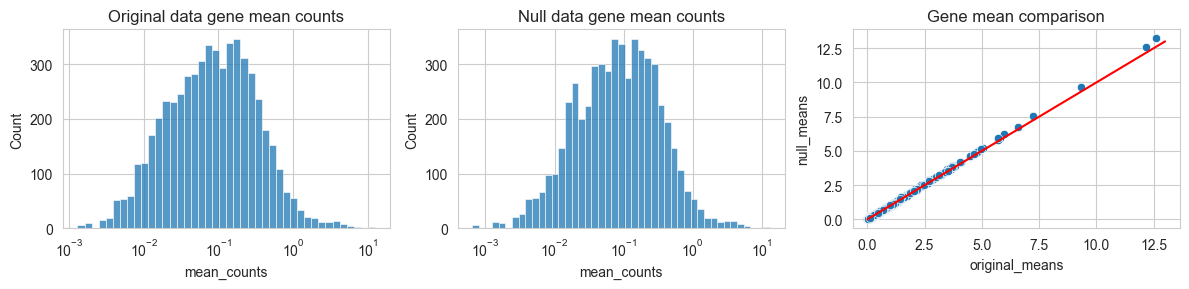

SignificanceResult(statistic=0.9963942019749005, pvalue=0.0)


In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
print(mean_df)
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df["original_means"], mean_df["null_means"]))


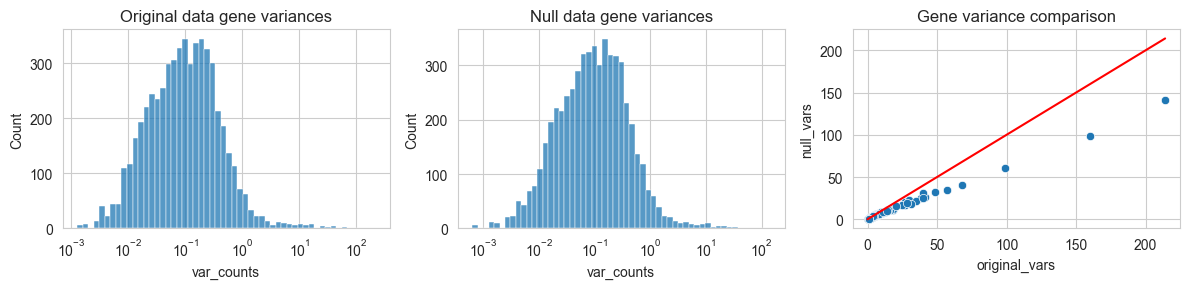

SignificanceResult(statistic=0.9946010527373397, pvalue=0.0)
[[1.         0.99727179]
 [0.99727179 1.        ]]


In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
var_df["diff"] = var_df["null_vars"] - var_df["original_vars"]

g = sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df["original_vars"], var_df["null_vars"]))
print(np.corrcoef(var_df["original_vars"], var_df["null_vars"]))

/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:288: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)


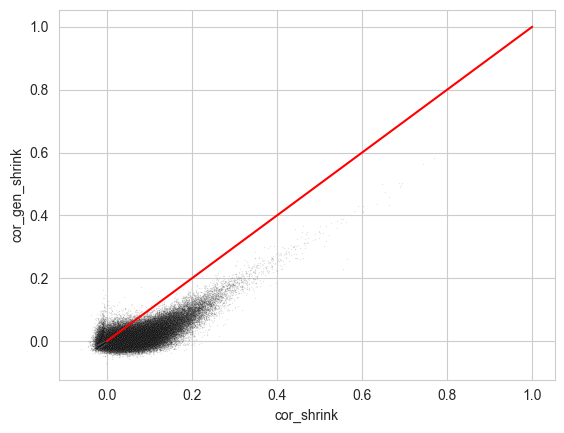

In [10]:
cor_orig = spearmanr(data_gene.layers["counts"].toarray()).statistic
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = spearmanr(data_null_gen.X).statistic
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

cor_shrink = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})
all_cors["ratio"] = all_cors["cor_orig"]/all_cors["cor_gen"]

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

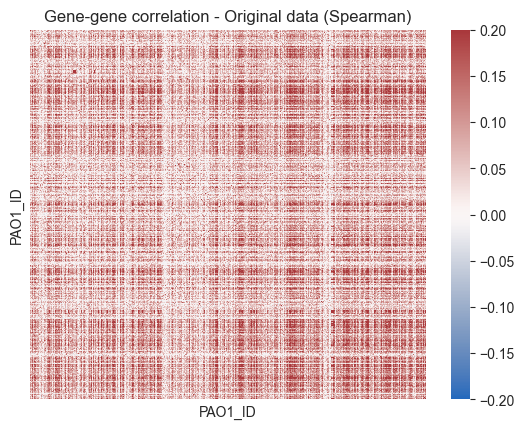

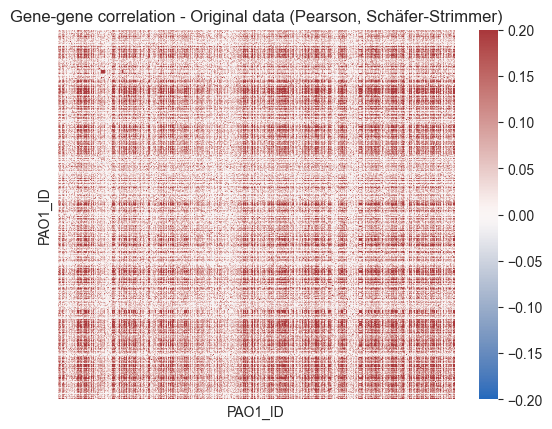

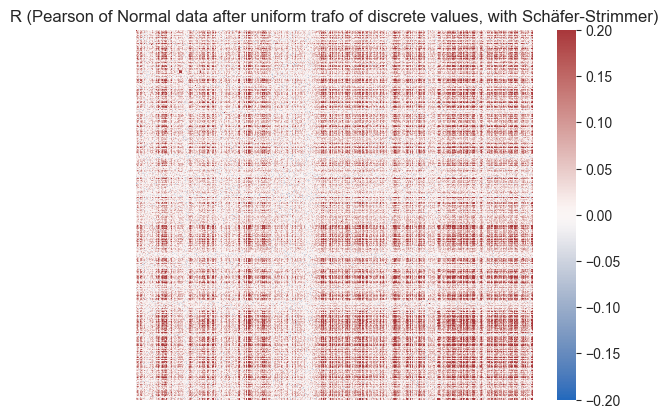

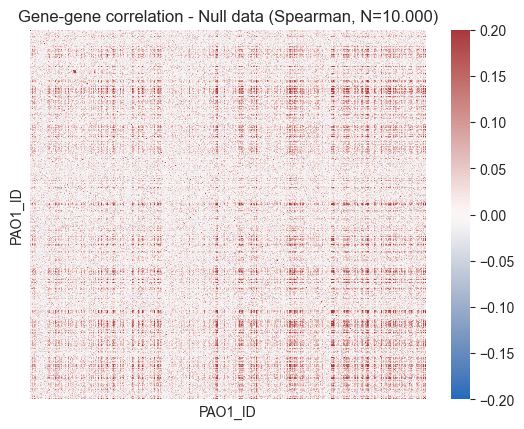

In [11]:
sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data (Spearman)")
plt.show()

sns.heatmap(cor_shrink,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data (Pearson, Schäfer-Strimmer)")
plt.show()

sns.heatmap(R_est,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R (Pearson of Normal data after uniform trafo of discrete values, with Schäfer-Strimmer)")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data (Spearman, N=10.000)")
plt.show()

## Correlation scaling

In [12]:
# Calculate mean ratio
# cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
# cor_gen = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen.X)
cor_ratio = np.mean(cor_orig)/np.mean(cor_gen)
print(cor_ratio)


1.0903341789539216


In [19]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen2, R_est2 = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1, R_est=None, check_pd=True)
data_null_gen2

AnnData object with n_obs × n_vars = 1544 × 5553

In [20]:
data_null_gen_new, R_est_new = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1.5, R_est=R_est, check_pd=True)
data_null_gen_new

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")


AnnData object with n_obs × n_vars = 1544 × 5553

In [21]:
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_gen = cd.schaefer_strimmer(data_null_gen_new.X, use_corr=True)

large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
print(frob)

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:287: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


415.2328991982995


In [28]:
from scipy.optimize import golden
importlib.reload(cd)

def opt_fun(factor):
    data_null_gen2, R_est_new = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=factor, R_est=R_est)
    cor_gen = cd.schaefer_strimmer(data_null_gen2.X, use_corr=True)

    large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
    frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
    if np.isnan(frob):
        frob = np.inf
    return frob

In [29]:
importlib.reload(cd)
xmin, fval, funcalls = golden(opt_fun, brack=(1, 2), full_output=True, maxiter=3)

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:287: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")
/Users/johannes.ostner/Documents

In [30]:
print(xmin)
print(fval)
print(funcalls)

1.14589803279532
286.5805205669762
8


In [31]:
importlib.reload(cd)
data_null_gen_opt, R_est_opt = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=xmin, R_est=R_est2)
data_null_gen_opt

AnnData object with n_obs × n_vars = 1544 × 5553

In [32]:
data_null_gen_opt.var_names = data_gene.var_names
sc.pp.calculate_qc_metrics(data_null_gen_opt)
data_null_gen_opt.var["var_counts"] = np.asarray(np.var(data_null_gen_opt.X, axis=0)).squeeze()
data_null_gen_opt.var["mean_counts"] = np.asarray(np.mean(data_null_gen_opt.X, axis=0)).squeeze()

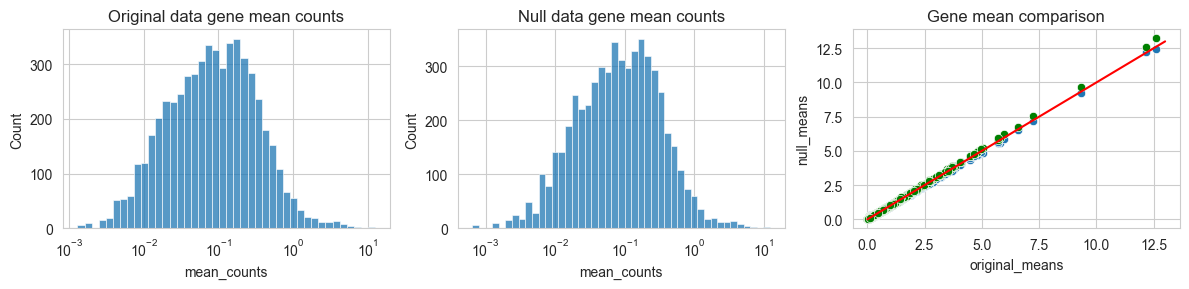

SignificanceResult(statistic=0.9963622344136609, pvalue=0.0)


In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen_opt.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen_opt.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2], color="green")
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

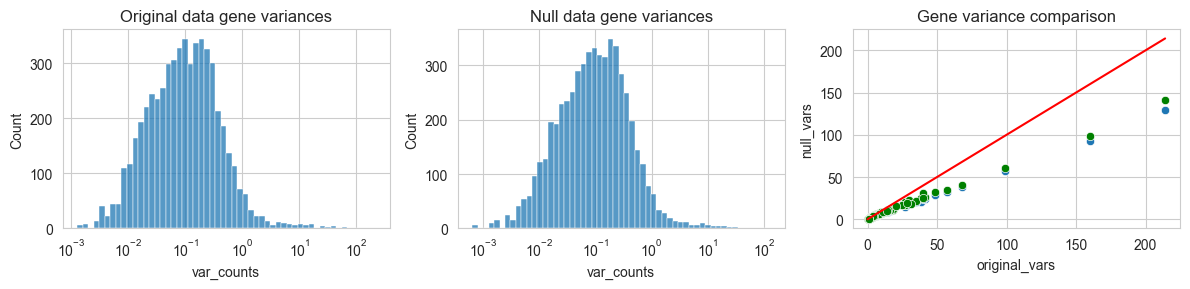

SignificanceResult(statistic=0.9945696712383469, pvalue=0.0)
[[1.         0.99735809]
 [0.99735809 1.        ]]


In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen_opt.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen_opt.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])
g = sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2], color="green")

# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

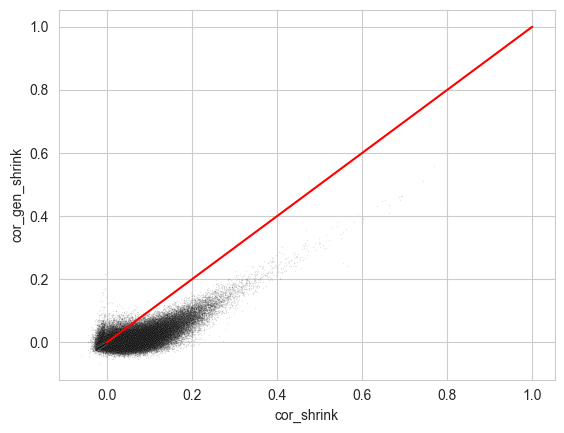

In [35]:
cor_shrink = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen_opt.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.show()

In [36]:
# cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
# cor_gen = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen_opt.X)
cor_ratio = np.mean(cor_orig)/np.mean(cor_gen)
print(cor_ratio)

1.1168623421695199


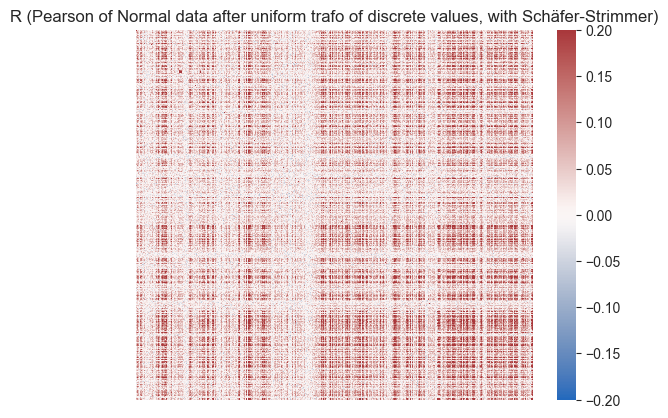

In [37]:
sns.heatmap(R_est_opt,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R (Pearson of Normal data after uniform trafo of discrete values, with Schäfer-Strimmer)")
plt.show()

## Shrinkage of covariance matrices

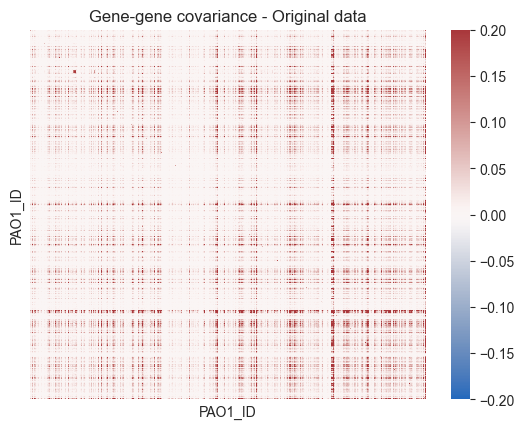

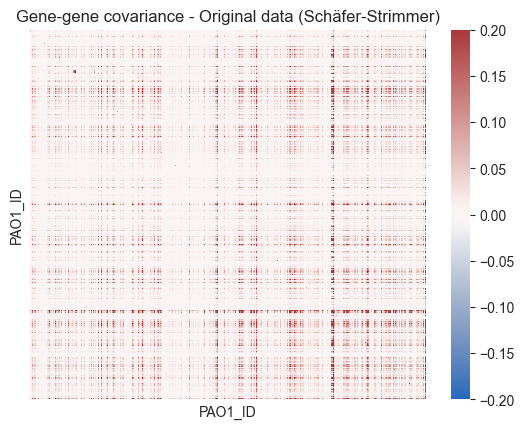

In [4]:
cov_orig = np.cov(data_gene.layers["counts"].toarray().T)
cov_orig = pd.DataFrame(cov_orig, index=data_gene.var_names, columns=data_gene.var_names)

cov_shrink = cd.schaefer_strimmer_2(data_gene.layers["counts"].toarray(), use_corr=False)
cov_shrink = pd.DataFrame(cov_shrink, index=data_gene.var_names, columns=data_gene.var_names)

sns.heatmap(cov_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene covariance - Original data")
plt.show()

sns.heatmap(cov_shrink,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene covariance - Original data (Schäfer-Strimmer)")
plt.show()

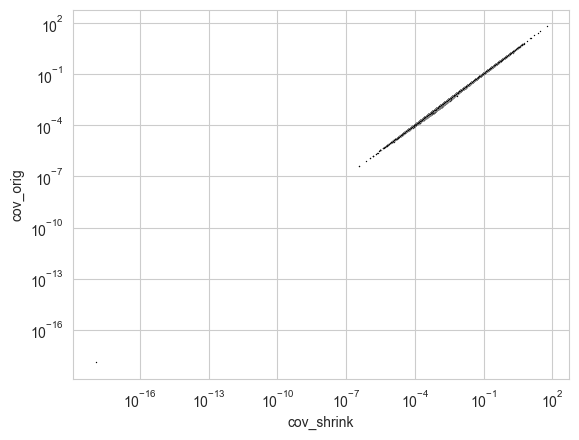

In [5]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_covs = pd.DataFrame({"cov_orig": cov_orig.values.flatten(), "cov_shrink": cov_shrink.values.flatten()})
all_covs["ratio"] = all_covs["cov_shrink"]/all_covs["cov_orig"]

ids = rng.choice(len(all_covs), 100000, replace=False)
all_covs_subset = all_covs.loc[ids]

g = sns.scatterplot(all_covs_subset, x="cov_shrink", y="cov_orig", s=1, color="black")
g.set(xscale="log", yscale="log")
# plt.plot([0, np.ceil(np.max(all_covs_subset['cov_orig']))], [0, np.ceil(np.max(all_covs_subset['cov_orig']))], color="red")
plt.show()

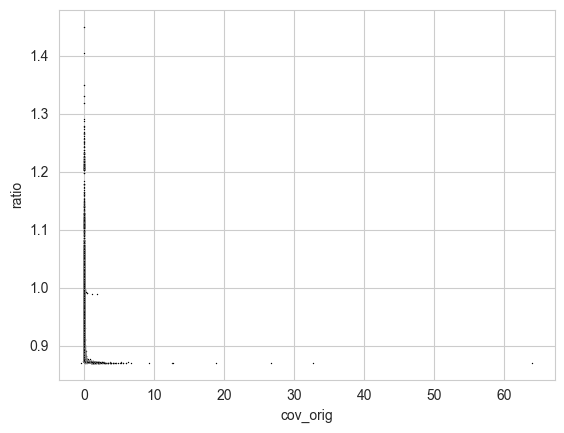

In [6]:
g = sns.scatterplot(all_covs_subset, x="cov_orig", y="ratio", s=1, color="black")


In [20]:

eigen_orig = np.linalg.eigvals(cov_orig.values)
print(eigen_orig)

eigen_shrink = np.linalg.eigvals(cov_shrink.values)


[1.41954495e+03+0.00000000e+00j 1.41094122e+02+0.00000000e+00j
 2.20460175e+01+0.00000000e+00j ... 4.79281898e-18-1.20774393e-18j
 7.97821972e-18+3.06245987e-19j 7.97821972e-18-3.06245987e-19j]


[None, None]

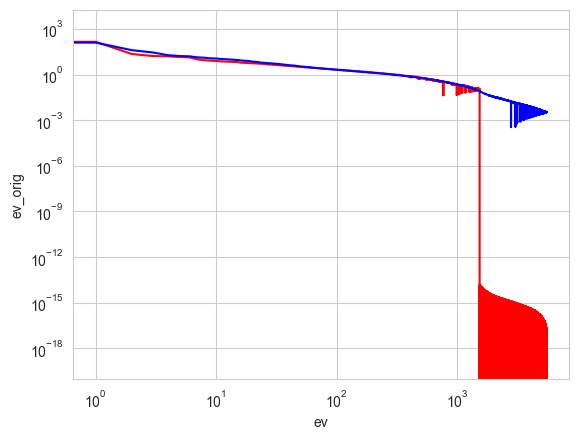

In [23]:
eigen_df = pd.DataFrame({
    "ev_orig": eigen_orig,
    "ev_shrink": eigen_shrink,
    "ev": np.arange(len(eigen_orig))
})

sns.lineplot(eigen_df, x="ev", y="ev_orig", color="red")
g = sns.lineplot(eigen_df, x="ev", y="ev_shrink", color="blue")
g.set(xscale="log", yscale="log")

In [224]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen.X)
cor_gen_opt = np.corrcoef(data_null_gen.X)


eigen_orig = np.linalg.eigvals(cor_orig)
print(eigen_orig)

eigen_gen = np.linalg.eigvals(cor_gen)
print(eigen_gen)

eigen_gen_opt = np.linalg.eigvals(cor_gen_opt)
print(eigen_gen_opt)

[7.23742274e+02 2.94704675e+01 1.12786048e+01 ... 1.08757799e-01
 1.07757960e-01 1.07781705e-01]
[6.76004635e+02 3.02677404e+01 1.67011686e+01 ... 8.38380360e-02
 8.79262772e-02 8.86145880e-02]
[6.76004635e+02 3.02677404e+01 1.67011686e+01 ... 8.38380360e-02
 8.79262772e-02 8.86145880e-02]


In [233]:
print(f"Without Schäfer-Strimmer: {np.linalg.eigvals(R_est)}")
print(f"With Schäfer-Strimmer: {np.linalg.eigvals(R_est2)}")
print(f"With Schäfer-Strimmer and scaling factor: {np.linalg.eigvals(R_est_opt)}")


Without Schäfer-Strimmer: [ 3.85040739e+02+0.00000000e+00j  6.09723353e+01+0.00000000e+00j
  2.07664013e+01+0.00000000e+00j ...  1.04788317e-17-2.09499113e-17j
 -4.25706930e-17+2.58029507e-17j -4.25706930e-17-2.58029507e-17j]
With Schäfer-Strimmer: [3.31679032e+02+0.j 5.26392971e+01+0.j 1.80198986e+01+0.j ...
 1.38948037e-01+0.j 1.38948037e-01+0.j 1.38948037e-01+0.j]
With Schäfer-Strimmer and scaling factor: [ 4.09741763e+02+0.00000000e+00j  6.48296816e+01+0.00000000e+00j
  2.20377517e+01+0.00000000e+00j ... -6.43187599e-02+3.80058872e-17j
 -6.43187599e-02-3.80058872e-17j -6.43187599e-02+0.00000000e+00j]


## Schäfer-Strimmer reimplementation

In [60]:
import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [61]:
%%R -o test

# load corpcor library
library("corpcor")

# small n, large p
p = 1000
n = 500

# generate random pxp covariance matrix
sigma = matrix(rnorm(p*p),ncol=p)
sigma = crossprod(sigma)+ diag(rep(0.1, p))

# simulate multinormal data of sample size n  
sigsvd = svd(sigma)
Y = t(sigsvd$v %*% (t(sigsvd$u) * sqrt(sigsvd$d)))
X = matrix(rnorm(n * ncol(sigma)), nrow = n) %*% Y


# estimate covariance matrix
s1 = cov(X)
start.time <- Sys.time()
s2 = cov.shrink(X)
end.time <- Sys.time()
time.taken <- end.time - start.time
print(time.taken)

test <- list(X = X, s1 = s1,s2 = s2)

Estimating optimal shrinkage intensity lambda.var (variance vector): 0.693 
Estimating optimal shrinkage intensity lambda (correlation matrix): 0.668 
Time difference of 3.009926 secs


In [62]:
s1 = test["s1"]
s2 = test["s2"]
X2 = test["X"]

In [63]:
importlib.reload(cd)

cov_shrink = cd.schaefer_strimmer_2(X2)
print(cov_shrink)

[[ 1.02562612e+03  1.67713597e+01 -2.16768278e+01 ... -2.83562115e+01
  -9.97915815e+00  8.22153056e+00]
 [ 1.67713597e+01  9.57937547e+02  2.35951711e+01 ... -3.72254745e-01
   1.73733691e+01 -4.41475280e+00]
 [-2.16768278e+01  2.35951711e+01  1.02568408e+03 ... -9.35042347e+00
   1.78627008e+01 -7.30674123e+00]
 ...
 [-2.83562115e+01 -3.72254745e-01 -9.35042347e+00 ...  1.00410062e+03
   9.15871740e+00  4.94143984e-01]
 [-9.97915815e+00  1.73733691e+01  1.78627008e+01 ...  9.15871740e+00
   1.02070925e+03  1.56851111e+01]
 [ 8.22153056e+00 -4.41475280e+00 -7.30674123e+00 ...  4.94143984e-01
   1.56851111e+01  1.03800681e+03]]


In [22]:
print(s2)


[[ 998.51388244   15.80490274    8.10683653 ...  -10.21304148
    -7.60213368  -25.59948625]
 [  15.80490274 1004.83872606   -1.13733715 ...   -7.87994003
   -14.14889121  -17.35413842]
 [   8.10683653   -1.13733715 1025.53453048 ...   -9.78969257
   -29.87075172   15.27860908]
 ...
 [ -10.21304148   -7.87994003   -9.78969257 ...  997.22064593
    -9.56703029    5.53281289]
 [  -7.60213368  -14.14889121  -29.87075172 ...   -9.56703029
  1006.0803866   -18.43464052]
 [ -25.59948625  -17.35413842   15.27860908 ...    5.53281289
   -18.43464052  991.05961721]]


In [23]:
print(np.max(np.abs(cov_shrink - s2)))

4.547473508864641e-13


In [18]:
importlib.reload(cd)
data_test = cd.schaefer_strimmer_2(data_gene.layers["counts"].toarray())